# İş Problemi
---

- Scout’lar tarafından izlenen futbolcuların özelliklerine verilen puanlara göre, oyuncuların hangi sınıf
(average, highlighted) oyuncu olduğunu tahminleme

# Veri Seti Hikayesi
---


- Veri seti Scoutium’dan maçlarda gözlemlenen futbolcuların özelliklerine göre scoutların değerlendirdikleri futbolcuların, maç
içerisinde puanlanan özellikleri ve puanlarını içeren bilgilerden oluşmaktadır.

**scoutium_attributes.csv**
- **task_response_id:** Bir scoutun bir maçta bir takımın kadrosundaki tüm oyunculara dair değerlendirmelerinin kümesi
- **match_id:** İlgili maçın id'si
- **evaluator_id:** Değerlendiricinin(scout'un) id'si
- **player_id:** İlgili oyuncunun id'si
- **position_id:** İlgili oyuncunun o maçta oynadığı pozisyonun id’si
1: Kaleci
2: Stoper
3: Sağ bek
4: Sol bek
5: Defansif orta saha
6: Merkez orta saha
7: Sağ kanat
8: Sol kanat
9: Ofansif orta saha
10: Forvet
- **analysis_id:** Bir scoutun bir maçta bir oyuncuya dair özellik değerlendirmelerini içeren küme
- **attribute_id:** Oyuncuların değerlendirildiği her bir özelliğin id'si
- **attribute_value:** Bir scoutun bir oyuncunun bir özelliğine verdiği değer(puan)

**scoutium_potential_labels.csv**
- **task_response_id:** Bir scoutun bir maçta bir takımın kadrosundaki tüm oyunculara dair değerlendirmelerinin kümesi
- **match_id:** İlgili maçın id'si
- **evaluator_id:** Değerlendiricinin(scout'un) id'si
- **player_id:** İlgili oyuncunun id'si
- **potential_label:** Bir scoutun bir maçta bir oyuncuyla ilgili nihai kararını belirten etiket. (hedef değişken)

In [104]:
# Adım 1: scoutium_attributes.csv ve scoutium_potential_labels.csv dosyalarını okutunuz.
import itertools
#pip install xgboost
#pip install catboost
import xgboost
import catboost
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 200)
from sklearn.model_selection import *
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_predict
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import warnings
warnings.filterwarnings('ignore')

In [105]:
df = pd.read_csv("scoutium_attributes.csv",sep=";")
df2 = pd.read_csv("scoutium_potential_labels.csv", sep=";")

In [106]:
df.head()

,task_response_id,match_id,evaluator_id,player_id,position_id,analysis_id,attribute_id,attribute_value
0,4915,62935,177676,1361061,2,12818495,4322,56.000
1,4915,62935,177676,1361061,2,12818495,4323,56.000
2,4915,62935,177676,1361061,2,12818495,4324,67.000
3,4915,62935,177676,1361061,2,12818495,4325,56.000
4,4915,62935,177676,1361061,2,12818495,4326,45.000


In [107]:
df2.head()

,task_response_id,match_id,evaluator_id,player_id,potential_label
0,4915,62935,177676,1361061,average
1,4915,62935,177676,1361626,highlighted
2,4915,62935,177676,1361858,average
3,4915,62935,177676,1362220,highlighted
4,4915,62935,177676,1364951,highlighted


In [108]:
#Adım 2: Okutmuş olduğumuz csv dosyalarını merge fonksiyonunu kullanarak birleştiriniz.
#("task_response_id", 'match_id', 'evaluator_id' "player_id" 4 adet değişken üzerinden birleştirme işlemini gerçekleştiriniz.)

dff = pd.merge(df, df2, how='left', on=["task_response_id", 'match_id', 'evaluator_id', "player_id"])

In [109]:
#Adım 3: position_id içerisindeki Kaleci (1) sınıfını veri setinden kaldırınız. (filtreleme yaptık.)
dff = dff[dff["position_id"] != 1]

In [110]:
#Görev 4: potential_label içerisindeki below_average sınıfını verisetinden kaldırınız.( below_average sınıfı  tüm verisetinin %1'ini oluşturur)

dff["potential_label"].value_counts()/dff["potential_label"].count()
#"dff" isimli DataFrame'in "potential_label" sütununda bulunan benzersiz değerlerin frekansını hesaplar ve bu değerlerin toplam sayısına bölerek,
#  her bir benzersiz değerin yüzdesini hesaplar. 
# Bu, "potential_label" sütununda bulunan her bir değerin veri setindeki oranını hesaplamaya yarar.



average         0.790
highlighted     0.197
below_average   0.014
Name: potential_label, dtype: float64

In [111]:
dff = dff[dff["potential_label"] != "below_average"]
# "dff" DataFrame'inde "potential_label" sütununda değeri "below_average" olan tüm satırları filtreleyerek yeni bir DataFrame oluşturur.
# Bu, "potential_label" sütununda "below_average" değerine sahip olan satırların çıkarılmasını sağlar.

In [112]:
#Görev 5: Oluşturduğunuz veri setinden “pivot_table” fonksiyonunu kullanarak bir tablo oluşturunuz. 
#Bu pivot table'da her satırda bir oyuncu olacak şekilde manipülasyon yapınız.

## Adım 1: İndekste “player_id”,“position_id” ve “potential_label”,  sütunlarda “attribute_id” ve değerlerde scout’ların oyunculara verdiği puan
# “attribute_value” olacak şekilde pivot table’ı oluşturunuz.
pt = pd.pivot_table(dff, values="attribute_value", columns="attribute_id", index=["player_id","position_id","potential_label"])
pt.head()

attribute_id                            4322   4323   4324   4325   4326   4327   4328   4329   4330   4332   4333   4335   4338   4339   4340   4341   4342   4343   4344   4345   4348   4349  \
player_id position_id potential_label                                                                                                                                                             
1355710   7           average         50.500 50.500 34.000 50.500 45.000 45.000 45.000 45.000 50.500 56.000 39.500 34.000 39.500 39.500 45.000 45.000 50.500 28.500 23.000 39.500 28.500 28.500   
1356362   9           average         67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 67.000 56.000 67.000 67.000 56.000   
1356375   3           average         67.000 67.000 67.000 67.000 67.000 67.000 67.000 78.000 67.000 67.000 78.000 56.000 67.000 67.000 67.000 67.000 67.000 56.000 56.000 67.000 67.000 56.000   
          4           average         67.000 78.000 67.000 67.000 67.000 78.000 78.000 78.000 56.000 67.000 67.000 67.000 78.000 78.000 56.000 67.000 67.000 45.000 45.000 56.000 67.000 67.000   
1356411   9           average         67.000 67.000 78.000 78.000 67.000 67.000 67.000 67.000 89.000 78.000 67.000 67.000 67.000 56.000 56.000 67.000 78.000 56.000 56.000 67.000 56.000 67.000   

attribute_id                            4350   4351   4352   4353   4354   4355   4356   4357   4407   4408   4423   4426  
player_id position_id potential_label                                                                                      
1355710   7           average         45.000 50.500 56.000 34.000 39.500 50.500 34.000 34.000 56.000 34.000 34.000 56.000  
1356362   9           average         67.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 67.000 67.000 56.000 78.000  
1356375   3           average         56.000 67.000 67.000 67.000 78.000 67.000 67.000 67.000 67.000 67.000 56.000 78.000  
          4           average         67.000 67.000 78.000 67.000 67.000 67.000 56.000 67.000 56.000 67.000 45.000 56.000  
1356411   9           average         56.000 67.000 67.000 56.000 67.000 67.000 56.000 67.000 89.000 56.000 67.000 78.000

In [113]:

#### 2. Yol####

#pt = dff.groupby(["player_id", "position_id", "potential_label", "attribute_id"])["attribute_value"].mean().unstack("attribute_id")
#pt.head()


In [114]:
#Adım 2: “reset_index” fonksiyonunu kullanarak index hatasından kurtulunuz ve “attribute_id” sütunlarının isimlerini stringe çeviriniz.

pt = pt.reset_index(drop=False)
pt.head()


attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,average,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,average,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


In [115]:
pt.columns = pt.columns.map(str)
pt.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426
0,1355710,7,average,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000
1,1356362,9,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
2,1356375,3,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000
3,1356375,4,average,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000
4,1356411,9,average,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000


In [116]:
#Sayısal değişken kolonlarını “num_cols” adıyla bir listeye atayınız.
num_cols = pt.columns[3:]

In [117]:
# GÖREV 4: KEŞİFCİ VERİ ANALİZİ
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(pt)

##################### Shape #####################
(271, 37)
##################### Types #####################
attribute_id
player_id            int64
position_id          int64
potential_label     object
4322               float64
4323               float64
4324               float64
4325               float64
4326               float64
4327               float64
4328               float64
4329               float64
4330               float64
4332               float64
4333               float64
4335               float64
4338               float64
4339               float64
4340               float64
4341               float64
4342               float64
4343               float64
4344               float64
4345               float64
4348               float64
4349               float64
4350               float64
4351               float64
4352               float64
4353               float64
4354               float64
4355               float64
4356               float64
4357         

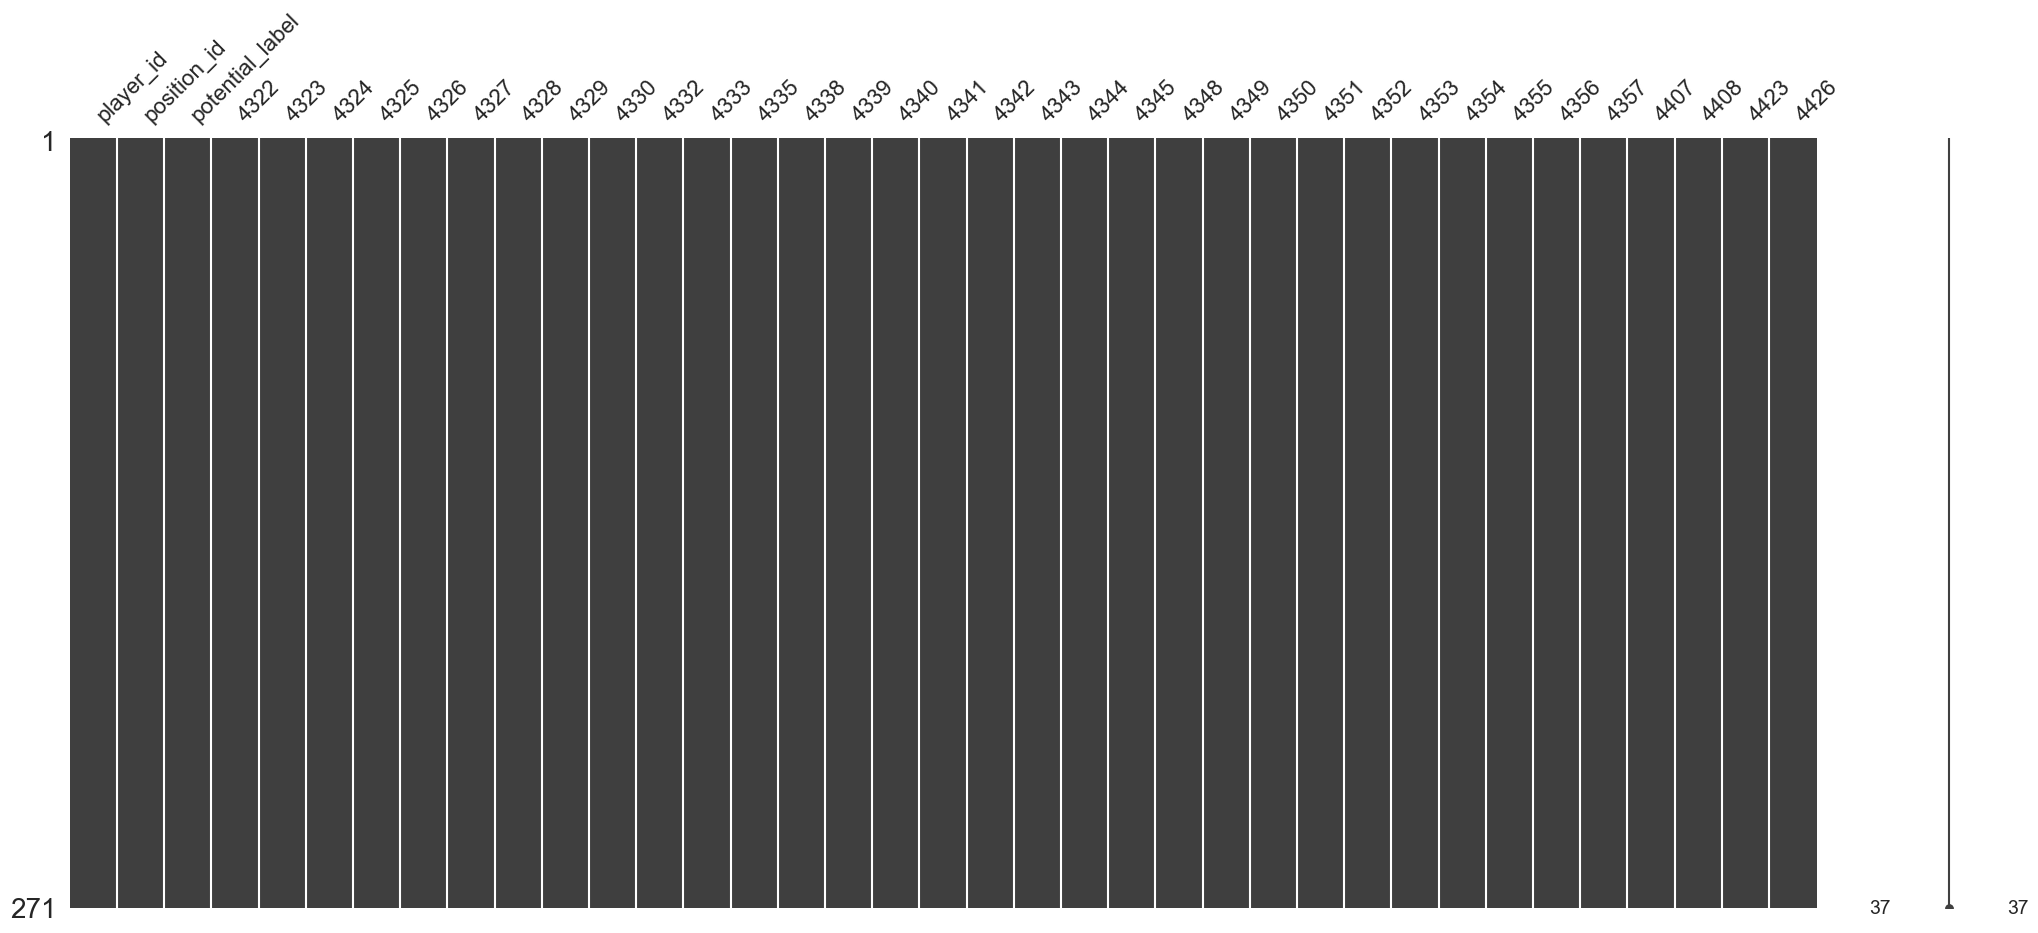

In [118]:
# eksik veri yapısının incelenmesi
#pip install missingno
import missingno as msno

msno.matrix(pt)
plt.show()

In [119]:
#Numerik ve kategorik değişkenleri inceleyiniz.
# KATEGORİK DEĞİŞKENLERİN ANALİZİ


def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

for col in ["position_id","potential_label"]:
    cat_summary(pt, col)

    position_id  Ratio
2            53 19.557
6            41 15.129
10           29 10.701
7            28 10.332
3            26  9.594
8            25  9.225
4            24  8.856
5            23  8.487
9            22  8.118
##########################################
             potential_label  Ratio
average                  215 79.336
highlighted               56 20.664
##########################################


In [120]:
# NUMERİK DEĞİŞKENLERİN ANALİZİ
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(pt, col, plot=False)

count   271.000
mean     58.368
std      14.527
min      23.000
5%       34.000
10%      34.000
20%      45.000
30%      56.000
40%      56.000
50%      56.000
60%      67.000
70%      67.000
80%      67.000
90%      78.000
95%      78.000
99%      78.000
max      89.000
Name: 4322, dtype: float64
count   271.000
mean     58.740
std      14.757
min      23.000
5%       34.000
10%      34.000
20%      45.000
30%      45.000
40%      56.000
50%      56.000
60%      67.000
70%      67.000
80%      72.500
90%      78.000
95%      78.000
99%      78.000
max      89.000
Name: 4323, dtype: float64
count   271.000
mean     56.250
std      15.868
min      23.000
5%       34.000
10%      34.000
20%      34.000
30%      45.000
40%      56.000
50%      56.000
60%      67.000
70%      67.000
80%      67.000
90%      78.000
95%      78.000
99%      78.000
max      78.000
Name: 4324, dtype: float64
count   271.000
mean     56.947
std      14.749
min      12.000
5%       34.000
10%      34.000
20%    

In [121]:
# Adım 3:  Numerik değişkenler ile hedef değişken incelemesini yapınız.
# NUMERİK DEĞİŞKENLERİN TARGET GÖRE ANALİZİ
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")



In [122]:
for col in num_cols:
    target_summary_with_num(pt, "potential_label", col)

attribute_id      4322
potential_label       
average         57.143
highlighted     63.071


attribute_id      4323
potential_label       
average         57.867
highlighted     62.089


attribute_id      4324
potential_label       
average         55.343
highlighted     59.732


attribute_id      4325
potential_label       
average         54.559
highlighted     66.116


attribute_id      4326
potential_label       
average         54.209
highlighted     64.446


attribute_id      4327
potential_label       
average         55.736
highlighted     59.536


attribute_id      4328
potential_label       
average         57.433
highlighted     61.304


attribute_id      4329
potential_label       
average         59.240
highlighted     60.812


attribute_id      4330
potential_label       
average         55.872
highlighted     60.223


attribute_id      4332
potential_label       
average         56.836
highlighted     60.812


attribute_id      4333
potential_label       
average       

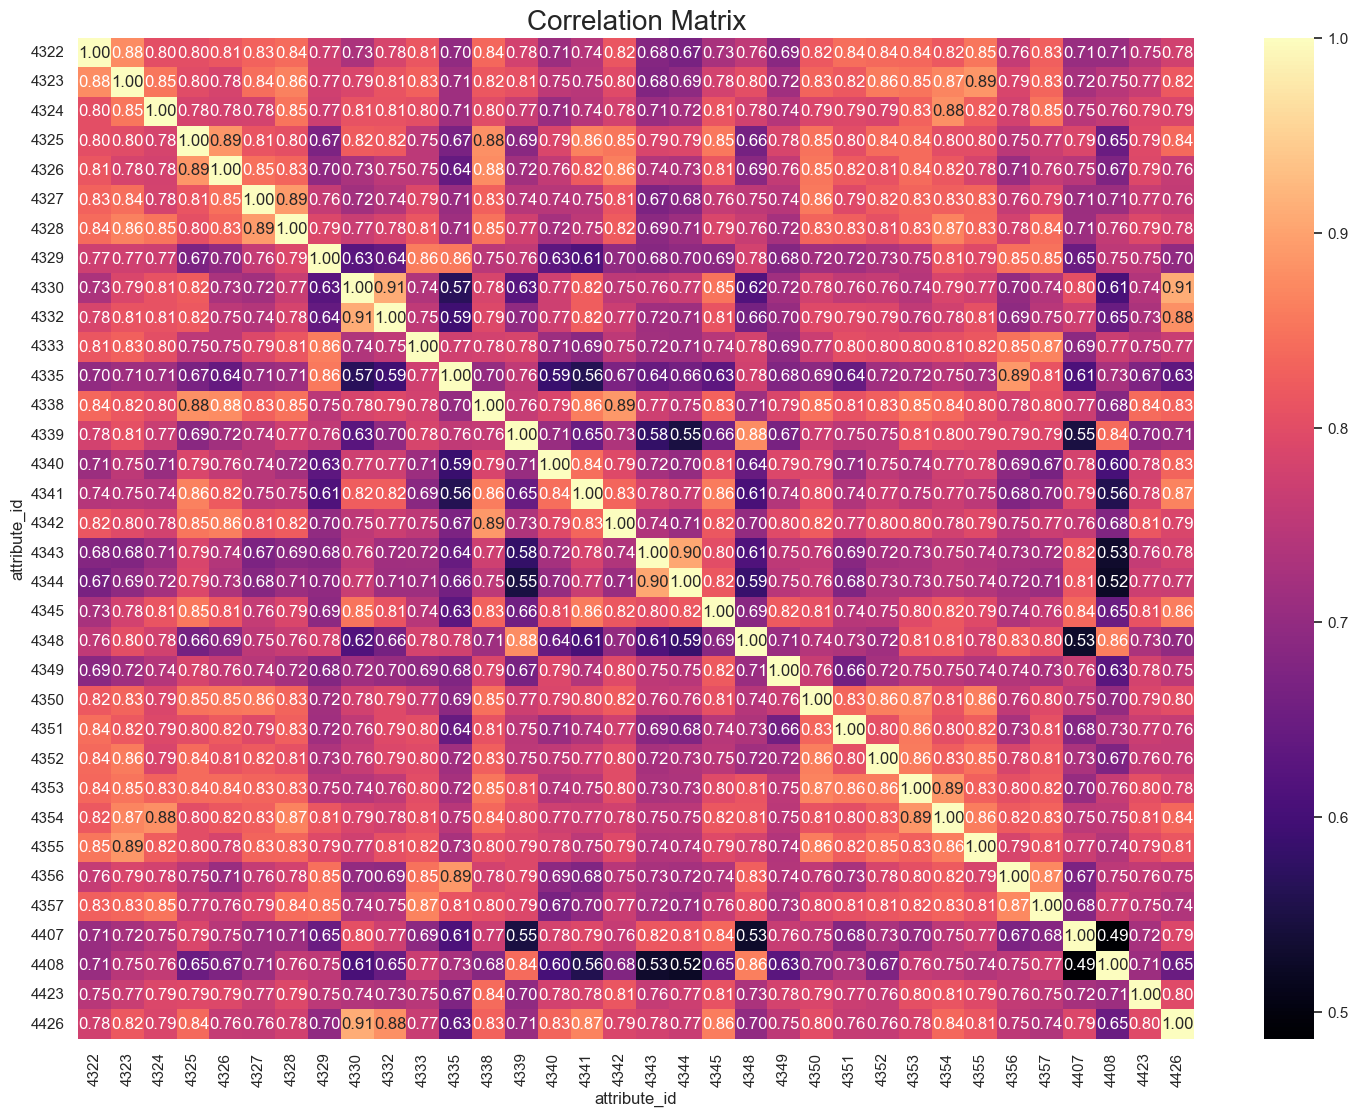

In [123]:
#Korelasyona bakınız.
# Korelasyon Matrisi
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(pt[num_cols].corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [124]:
#Feature Extraction uygulayın.
"""
Feature Extraction, makine öğrenmesi ve veri madenciliği gibi disiplinlerde, verilerin özelliklerini (features) çıkarma işlemidir. 
Veriler genellikle, birçok farklı özellik ya da boyuttan oluşur ve bu özellikler veri setindeki her bir öğenin (instance) tanımlanmasında kullanılabilir.

Feature Extraction işlemi, verilerin anlaşılmasını ve daha iyi bir şekilde kullanılabilmesini sağlayabilir. 
Özellikle, büyük ve karmaşık veri kümelerinde, veri boyutunu azaltmak için sıklıkla kullanılır. 
Feature Extraction işlemi, verilerin anlamlı bir şekilde ifade edilmesini ve birçok farklı özellikten oluşan verilerin daha az sayıda, daha anlamlı 
özelliklere indirgenmesini sağlar
"""

pt["min"] = pt[num_cols].min(axis=1)
pt["max"] = pt[num_cols].max(axis=1)
pt["sum"] = pt[num_cols].sum(axis=1)
pt["mean"] = pt[num_cols].mean(axis=1)
pt["median"] = pt[num_cols].median(axis=1)

- pt[num_cols].min(axis=1) : num_cols değişkeninde tanımlanan sayısal özellikler için her satırın en küçük değerini hesaplar ve min adı altında yeni bir özellik olarak pt DataFrame'ine ekler.
- pt[num_cols].max(axis=1) : num_cols değişkeninde tanımlanan sayısal özellikler için her satırın en büyük değerini hesaplar ve max adı altında yeni bir özellik olarak pt DataFrame'ine ekler.
- pt[num_cols].sum(axis=1) : num_cols değişkeninde tanımlanan sayısal özellikler için her satırın toplamını hesaplar ve sum adı altında yeni bir özellik olarak pt DataFrame'ine ekler.
- pt[num_cols].mean(axis=1) : num_cols değişkeninde tanımlanan sayısal özellikler için her satırın ortalamasını hesaplar ve mean adı altında yeni bir özellik olarak - pt DataFrame'ine ekler. 
- pt[num_cols].median(axis=1) : num_cols değişkeninde tanımlanan sayısal özellikler için her satırın ortanca değerini hesaplar ve median adı altında yeni bir özellik olarak pt DataFrame'ine ekler.

In [125]:
pt.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426,min,max,sum,mean,median
0,1355710,7,average,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000,23.000,56.000,1436.500,42.250,45.000
1,1356362,9,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000,56.000,78.000,2267.000,66.676,67.000
2,1356375,3,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000,56.000,78.000,2256.000,66.353,67.000
3,1356375,4,average,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000,45.000,78.000,2223.000,65.382,67.000
4,1356411,9,average,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000,56.000,89.000,2278.000,67.000,67.000


In [126]:
pt["mentality"] = pt["position_id"].apply(lambda x: "defender" if (x == 2) | (x == 5) | (x == 3) | (x == 4) else "attacker")


- Bu kod, pt pivot tablosunda bulunan position_id sütununu kullanarak her bir satırın pozisyonunu belirler. Eğer pozisyon "defans oyuncusu" ise, mentality sütununda "defender" değeri atanır. Eğer pozisyon "forvet oyuncusu" ise, mentality sütununda "attacker" değeri atanır. Böylece mentality sütunu, pozisyona göre oyuncuların ruhsal durumunu (defans veya atak) belirtmek için kullanılabilir. apply fonksiyonu, her satırın position_id değerini alır ve koşula göre "defender" veya "attacker" döndürür. lambda fonksiyonu ise bu koşulu tanımlamak için kullanılır.

In [127]:
for i in pt.columns[3:-6]:
    threshold = pt[i].mean() + pt[i].std()

    lst = pt[i].apply(lambda x: 0 if x < threshold else 1)
    pt[str(i) + "_FLAG"] = lst


- Bu kod, pt pivot tablosunda bulunan sayısal değerlerin (üçüncü sütundan, son altı sütuna kadar olanlar) her birinin için belirli bir eşik değeri hesaplar. Bu eşik değeri, her bir sütundaki sayısal değerlerin ortalamasına standart sapmayı ekleyerek belirlenir.

- Daha sonra, her bir sayısal değer için eşik değeri kullanarak, apply fonksiyonu ve lambda ifadesi yardımıyla, bu sayısal değer eşik değerden büyükse 1, küçükse 0 olarak kodlanır. Bu işlemin sonucu olarak, her bir sayısal değer için bir FLAG sütunu oluşturulur ve bu sütunlar, sayısal değerlerin eşik değerine göre üstünde veya altında olup olmadıklarını belirtmek için kullanılır.

- Bu yöntem, veri setindeki sayısal değerlerin, belirli bir eşik değeri üzerinde veya altında olanları işaretlemek ve bu şekilde bir veri setinin daha kolay anlaşılmasını sağlamak için kullanılır. Bu tür işaretleme, veri setindeki sayısal değişkenlerin özelliklerinin daha kolay analiz edilmesine ve yorumlanmasına olanak tanır.

In [128]:

flagCols = [col for col in pt.columns if "_FLAG" in col]

- Bu kod pt veri çerçevesindeki sütunlardan sadece "_FLAG" ifadesi içeren sütunları flagCols adlı bir listede toplar. _FLAG ifadesi sütun adında, bu sütunlara ait değerlerin, bir önceki adımda yapılan eşik değeri kontrolü sonucu 0 veya 1 değerlerini alıp, binary bir format oluşturduğunu gösterir. 

- Bu sütunlar veri setindeki ilgili özniteliklerin, eşik değerine göre belirlenen bir "threshold" altında veya üstünde kalıp kalmadığını gösterir.

In [129]:
pt["counts"] = pt[flagCols].sum(axis=1)

In [130]:
pt["countRatio"] = pt["counts"] / len(flagCols)

In [131]:
pt.head()


attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426,min,max,sum,mean,median,mentality,4322_FLAG,4323_FLAG,4324_FLAG,4325_FLAG,4326_FLAG,4327_FLAG,4328_FLAG,4329_FLAG,4330_FLAG,4332_FLAG,4333_FLAG,4335_FLAG,4338_FLAG,4339_FLAG,4340_FLAG,4341_FLAG,4342_FLAG,4343_FLAG,4344_FLAG,4345_FLAG,4348_FLAG,4349_FLAG,4350_FLAG,4351_FLAG,4352_FLAG,4353_FLAG,4354_FLAG,4355_FLAG,4356_FLAG,4357_FLAG,4407_FLAG,4408_FLAG,4423_FLAG,4426_FLAG,counts,countRatio
0,1355710,7,average,50.500,50.500,34.000,50.500,45.000,45.000,45.000,45.000,50.500,56.000,39.500,34.000,39.500,39.500,45.000,45.000,50.500,28.500,23.000,39.500,28.500,28.500,45.000,50.500,56.000,34.000,39.500,50.500,34.000,34.000,56.000,34.000,34.000,56.000,23.000,56.000,1436.500,42.250,45.000,attacker,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000
1,1356362,9,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000,56.000,78.000,2267.000,66.676,67.000,attacker,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,3,0.088
2,1356375,3,average,67.000,67.000,67.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,78.000,56.000,67.000,67.000,67.000,67.000,67.000,56.000,56.000,67.000,67.000,56.000,56.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,67.000,67.000,56.000,78.000,56.000,78.000,2256.000,66.353,67.000,defender,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,4,0.118
3,1356375,4,average,67.000,78.000,67.000,67.000,67.000,78.000,78.000,78.000,56.000,67.000,67.000,67.000,78.000,78.000,56.000,67.000,67.000,45.000,45.000,56.000,67.000,67.000,67.000,67.000,78.000,67.000,67.000,67.000,56.000,67.000,56.000,67.000,45.000,56.000,45.000,78.000,2223.000,65.382,67.000,defender,0,1,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,8,0.235
4,1356411,9,average,67.000,67.000,78.000,78.000,67.000,67.000,67.000,67.000,89.000,78.000,67.000,67.000,67.000,56.000,56.000,67.000,78.000,56.000,56.000,67.000,56.000,67.000,56.000,67.000,67.000,56.000,67.000,67.000,56.000,67.000,89.000,56.000,67.000,78.000,56.000,89.000,2278.000,67.000,67.000,attacker,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,9,0.265


In [132]:
#Görev 6:  Label Encoder fonksiyonunu kullanarak “potential_label” kategorilerini (average, highlighted) sayısal olarak ifade ediniz.
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


labelEncoderCols = ["potential_label","mentality"]

for col in labelEncoderCols:
    pt = label_encoder(pt, col)

In [133]:
# Görev 7: Kaydettiğiniz bütün “num_cols” değişkenlerindeki veriyi ölçeklendirmek için standardScaler uygulayınız.pt.head()
lst = ["counts", "countRatio","min","max","sum","mean","median"]
num_cols = list(num_cols)

for i in lst:
    num_cols.append(i)

scaler = StandardScaler()
pt[num_cols] = scaler.fit_transform(pt[num_cols])

pt.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426,min,max,sum,mean,median,mentality,4322_FLAG,4323_FLAG,4324_FLAG,4325_FLAG,4326_FLAG,4327_FLAG,4328_FLAG,4329_FLAG,4330_FLAG,4332_FLAG,4333_FLAG,4335_FLAG,4338_FLAG,4339_FLAG,4340_FLAG,4341_FLAG,4342_FLAG,4343_FLAG,4344_FLAG,4345_FLAG,4348_FLAG,4349_FLAG,4350_FLAG,4351_FLAG,4352_FLAG,4353_FLAG,4354_FLAG,4355_FLAG,4356_FLAG,4357_FLAG,4407_FLAG,4408_FLAG,4423_FLAG,4426_FLAG,counts,countRatio
0,1355710,7,0,-0.543,-0.559,-1.405,-0.438,-0.767,-0.795,-0.907,-0.792,-0.446,-0.123,-1.224,-1.036,-1.126,-1.009,-0.542,-0.690,-0.535,-1.067,-1.206,-1.005,-1.314,-1.042,-0.693,-0.436,0.013,-1.282,-1.132,-0.495,-1.235,-1.520,-0.143,-1.487,-0.955,-0.253,-1.008,-1.071,-0.959,-0.959,-0.747,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.815,-0.815
1,1356362,9,0,0.595,0.561,0.679,0.683,0.723,0.723,0.601,0.404,0.728,0.691,0.459,0.996,0.632,0.840,0.912,0.799,0.588,1.230,0.750,0.742,0.879,0.670,0.848,0.717,0.787,0.814,1.053,0.632,0.915,0.768,0.530,0.669,0.404,1.042,1.093,0.663,0.843,0.843,0.858,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-0.305,-0.305
2,1356375,3,0,0.595,0.561,0.679,0.683,0.723,0.723,0.601,1.002,0.728,0.691,1.132,0.319,0.632,0.840,0.912,0.799,0.588,0.574,0.750,0.742,0.879,0.670,0.077,0.717,0.787,0.814,1.053,0.632,0.915,0.768,0.530,0.669,0.404,1.042,1.093,0.663,0.819,0.819,0.858,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,-0.135,-0.135
3,1356375,4,0,0.595,1.308,0.679,0.683,0.723,1.482,1.355,1.002,-0.055,0.691,0.459,0.996,1.335,1.580,0.185,0.799,0.588,-0.083,0.098,0.043,0.879,1.355,0.848,0.717,1.560,0.814,0.428,0.632,0.198,0.768,-0.143,0.669,-0.276,-0.253,0.393,0.663,0.747,0.747,0.858,1,0,1,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0.544,0.544
4,1356411,9,0,0.595,0.561,1.373,1.430,0.723,0.723,0.601,0.404,2.294,1.505,0.459,0.996,0.632,0.101,0.185,0.799,1.337,0.574,0.750,0.742,0.252,1.355,0.077,0.717,0.787,0.115,0.428,0.632,0.198,0.768,1.874,-0.050,1.083,1.042,1.093,1.529,0.867,0.867,0.858,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0.714,0.714


In [134]:
# Görev 8: Elimizdeki veri seti üzerinden minimum hata ile futbolcuların potansiyel etiketlerini tahmin eden bir makine öğrenmesi modeli geliştiriniz.

y = pt["potential_label"]
X = pt.drop(["potential_label", "player_id"], axis=1)




In [135]:
models = [('LR', LogisticRegression()),
                   ('KNN', KNeighborsClassifier()),
                   #("SVC", SVC()),
                   #("CART", DecisionTreeClassifier()),
                   ("RF", RandomForestClassifier()),
                   #('Adaboost', AdaBoostClassifier()),
                   ('GBM', GradientBoostingClassifier()),
                   ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                   ('CatBoost', CatBoostClassifier(verbose=False)),
              ("LightGBM", LGBMClassifier())]


In [136]:
for name, model in models:
    print(name)
    for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
        cvs = cross_val_score(model, X, y, scoring=score, cv=10).mean()
        print(score+" score:"+str(cvs))

LR
roc_auc score:0.8844805194805195
f1 score:0.6211111111111112
precision score:0.7978571428571428
recall score:0.5466666666666666
accuracy score:0.8671957671957671
KNN
roc_auc score:0.7225541125541125
f1 score:0.4167748917748918
precision score:0.78
recall score:0.30666666666666664
accuracy score:0.84484126984127
RF
roc_auc score:0.9026623376623377
f1 score:0.5828138528138528
precision score:0.775
recall score:0.45666666666666667
accuracy score:0.8744708994708995
GBM
roc_auc score:0.8594155844155844
f1 score:0.558939393939394
precision score:0.7224999999999999
recall score:0.5733333333333333
accuracy score:0.8488095238095237
XGBoost
roc_auc score:0.8779509379509379
f1 score:0.6528538128538128
precision score:0.7930952380952381
recall score:0.5933333333333333
accuracy score:0.8781746031746032
CatBoost
roc_auc score:0.8919913419913421
f1 score:0.559978354978355
precision score:0.865
recall score:0.4533333333333333
accuracy score:0.8673280423280424
LightGBM
roc_auc score:0.89360750360750

In [137]:
# Görev 9: Hiperparametre Optimizasyonu yapınız.

lgbm_model = LGBMClassifier(random_state=46)

lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500, 1500],
               "colsample_bytree": [0.5, 0.7, 1]
             }

In [138]:
lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=10,
                            n_jobs=-1,
                            verbose=True).fit(X, y)


Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [139]:
final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
    cvs = cross_val_score(final_model, X, y, scoring=score, cv=10).mean()
    print(score + " score:" + str(cvs))

roc_auc score:0.893968253968254
f1 score:0.680920190920191
precision score:0.9114285714285714
recall score:0.5966666666666667
accuracy score:0.8966931216931217


In [140]:
# Görev 10: Değişkenlerin önem düzeyini belirten feature_importance fonksiyonunu kullanarak özelliklerin sıralamasını çizdiriniz.

# feature importance
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

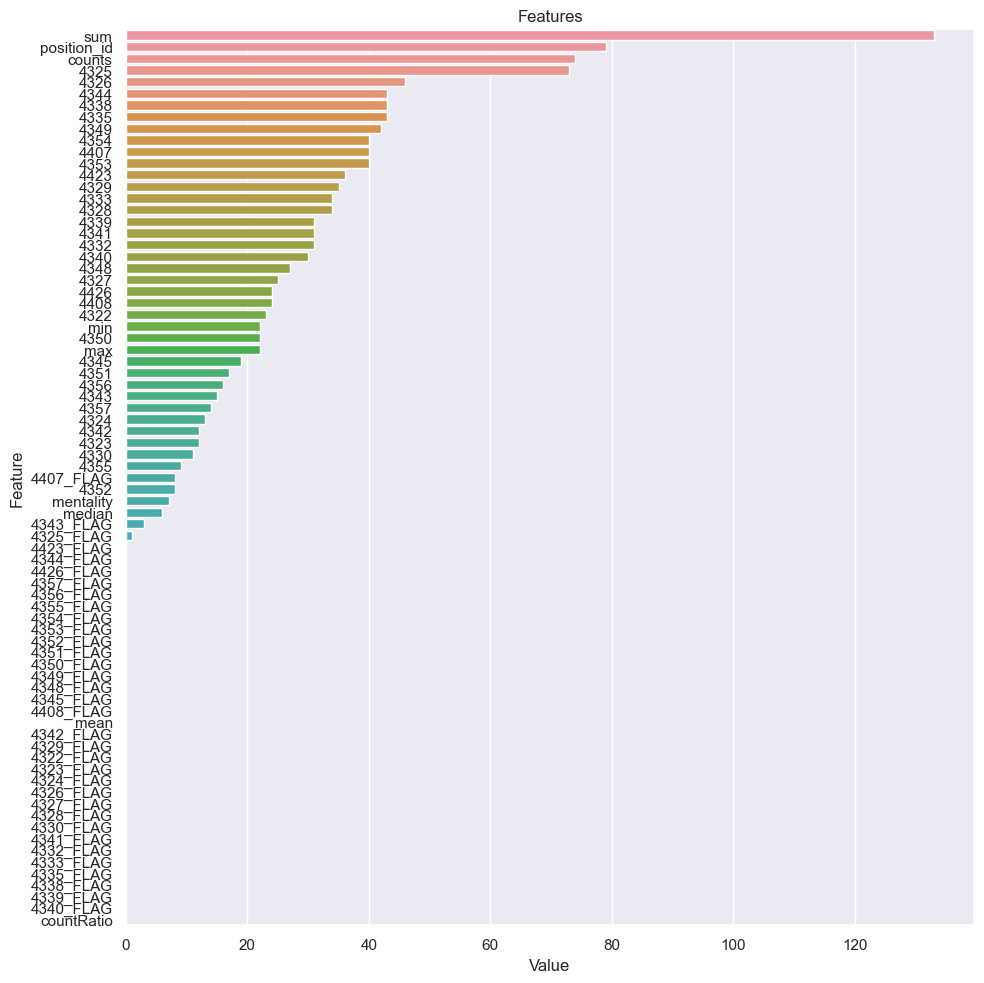

In [141]:
model = LGBMClassifier()
model.fit(X, y)

plot_importance(model, X)

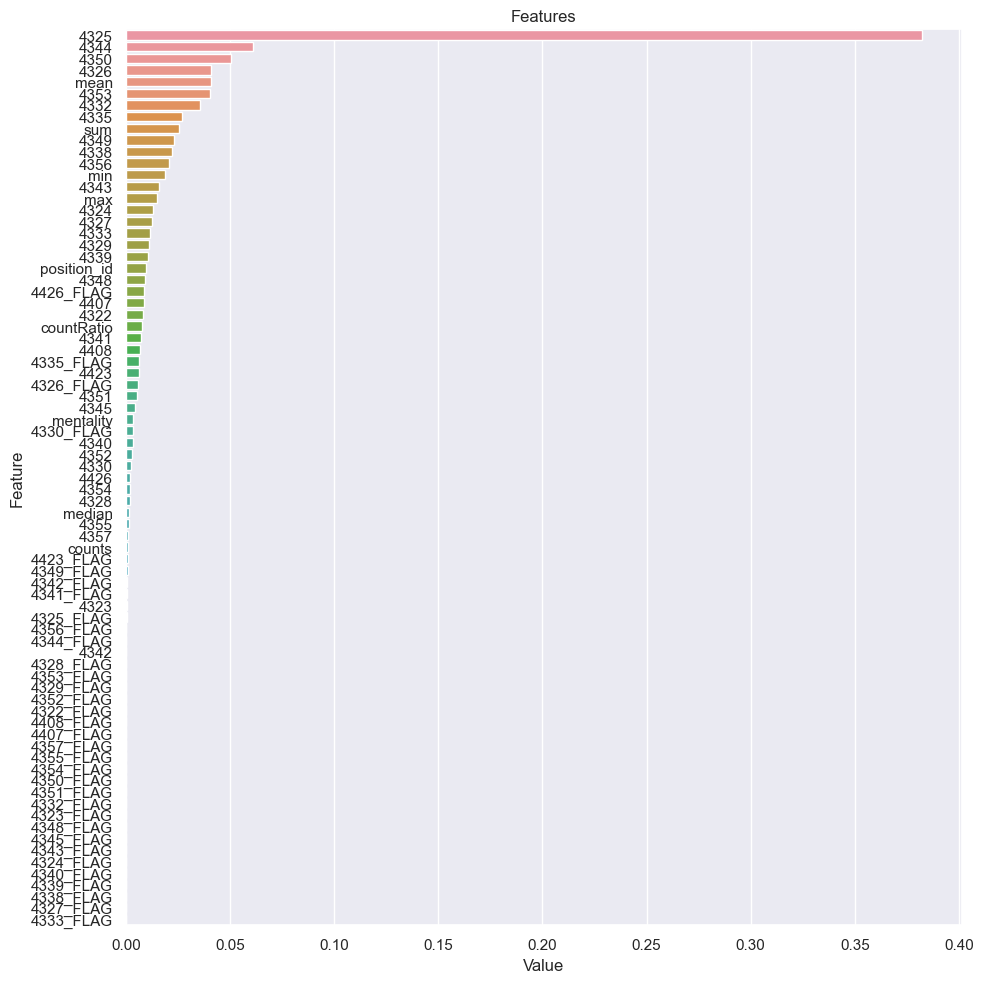

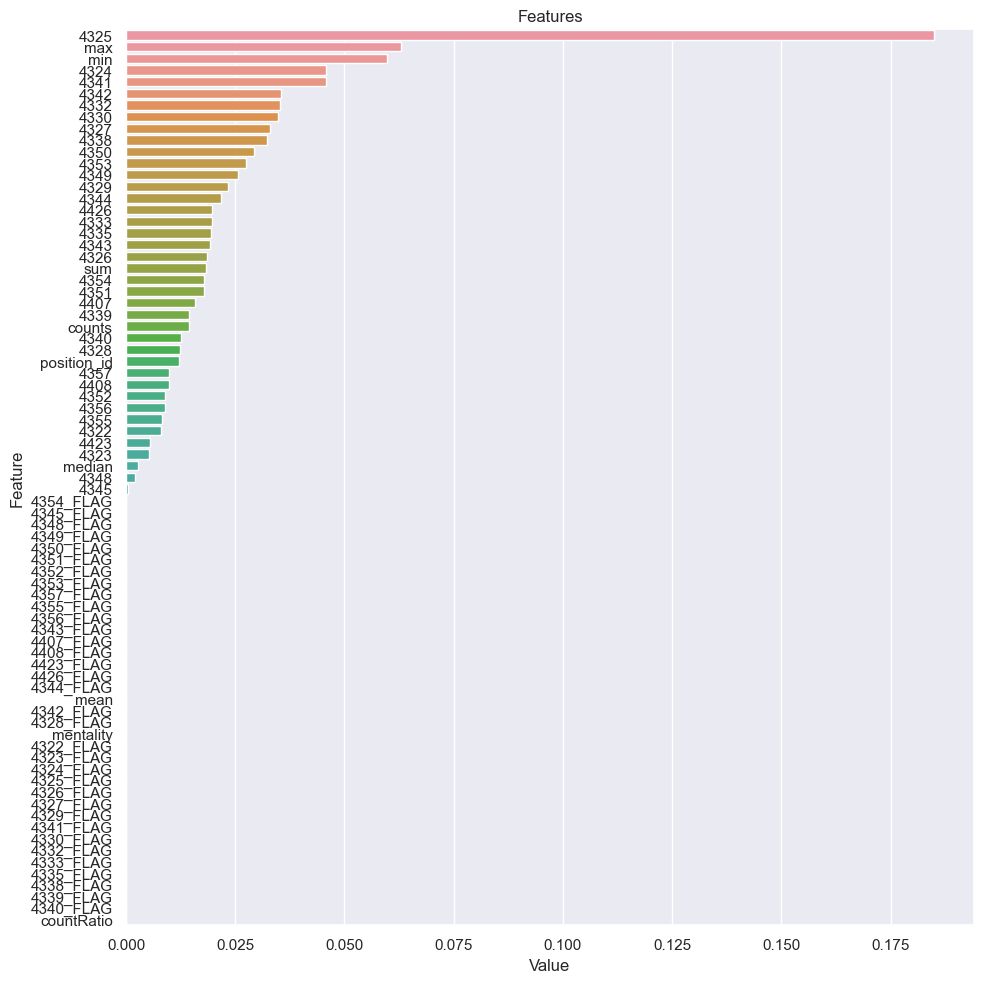

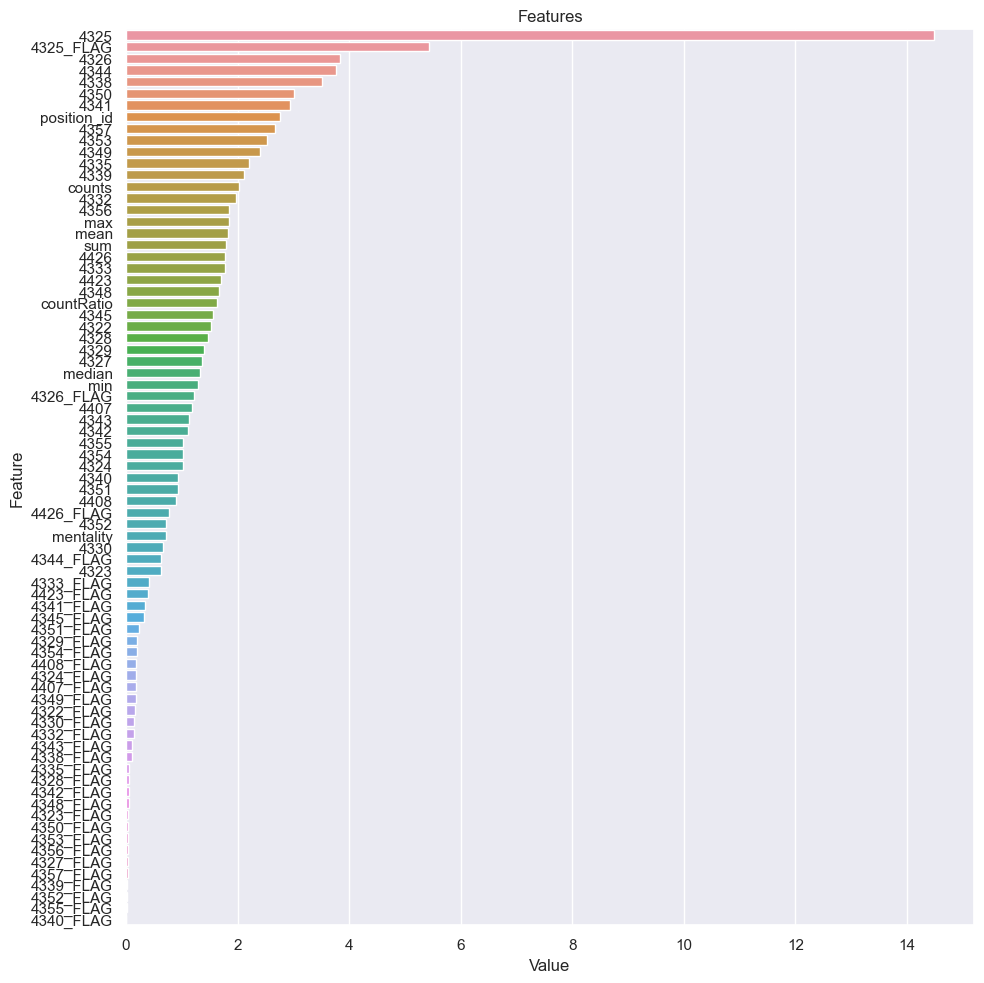

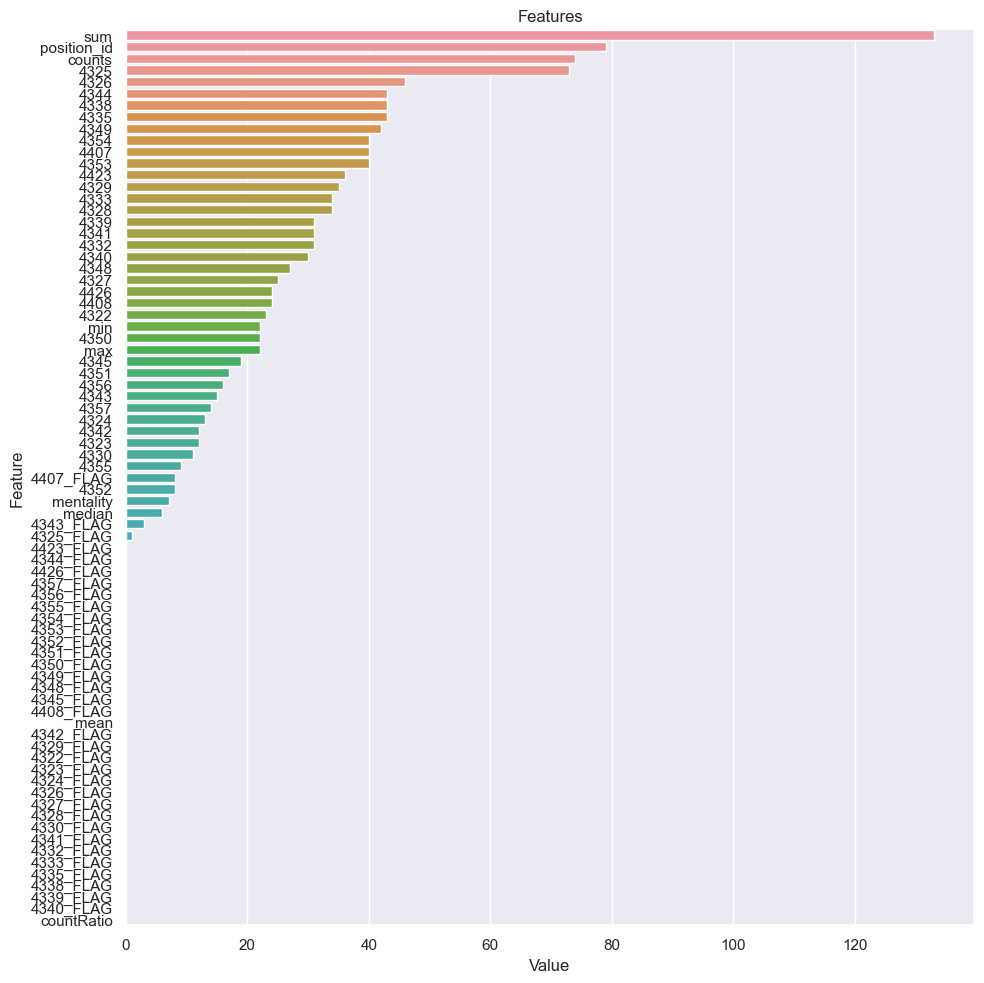

In [142]:
for name, model in models[3:]:
    model=model.fit(X,y)
    plot_importance(model, X)